In [1]:
%pip install numpy pandas scikit-learn tqdm seaborn matplotlib xgboost deap imbalanced-learn --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# Comparative Study Between Ensemble Learning and Evolutionary Learning to solve the Higgs Bozon Detection

In [2]:
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.decomposition import PCA

import xgboost as xgb
from deap import base, creator, tools, algorithms

import matplotlib.pyplot as plt

## Data loading

In [3]:
dataFilename = './atlas-higgs.csv'
data = pd.read_csv(dataFilename)

print(data.shape)
print(data.dtypes)

(818238, 35)
EventId                          int64
DER_mass_MMC                   float64
DER_mass_transverse_met_lep    float64
DER_mass_vis                   float64
DER_pt_h                       float64
DER_deltaeta_jet_jet           float64
DER_mass_jet_jet               float64
DER_prodeta_jet_jet            float64
DER_deltar_tau_lep             float64
DER_pt_tot                     float64
DER_sum_pt                     float64
DER_pt_ratio_lep_tau           float64
DER_met_phi_centrality         float64
DER_lep_eta_centrality         float64
PRI_tau_pt                     float64
PRI_tau_eta                    float64
PRI_tau_phi                    float64
PRI_lep_pt                     float64
PRI_lep_eta                    float64
PRI_lep_phi                    float64
PRI_met                        float64
PRI_met_phi                    float64
PRI_met_sumet                  float64
PRI_jet_num                      int64
PRI_jet_leading_pt             float64
PRI_jet_lead

In [4]:
data.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.00,-999.000,46.226,0.681042,b,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0.715742,b,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,1.660654,b,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.904263,b,t,6.245333


## Data cleaning

In [5]:
del(data['EventId'])
del(data['Weight'])
del(data['KaggleSet'])
del(data['KaggleWeight'])

Encoder = LabelEncoder()

data['Label'] = Encoder.fit_transform(data['Label'])

data

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Label
0,138.470,51.655,97.827,27.980,0.910,124.711,2.666,3.064,41.928,197.760,...,258.733,2,67.435,2.150,0.444,46.062,1.240,-2.475,113.497,1
1,160.937,68.768,103.235,48.146,-999.000,-999.000,-999.000,3.473,2.078,125.157,...,164.546,1,46.226,0.725,1.158,-999.000,-999.000,-999.000,46.226,0
2,-999.000,162.172,125.953,35.635,-999.000,-999.000,-999.000,3.148,9.336,197.814,...,260.414,1,44.251,2.053,-2.028,-999.000,-999.000,-999.000,44.251,0
3,143.905,81.417,80.943,0.414,-999.000,-999.000,-999.000,3.310,0.414,75.968,...,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000,0
4,175.864,16.915,134.805,16.405,-999.000,-999.000,-999.000,3.891,16.405,57.983,...,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818233,105.668,46.443,60.048,156.191,0.403,47.746,0.936,1.279,6.133,256.853,...,303.668,2,112.264,1.190,-0.766,41.791,0.787,-1.090,154.056,1
818234,99.294,30.097,62.713,65.861,3.312,471.319,-2.611,2.294,2.889,248.582,...,266.919,2,108.698,1.293,-0.868,70.158,-2.018,2.893,178.856,1
818235,108.497,9.837,65.149,18.006,-999.000,-999.000,-999.000,2.742,18.006,68.097,...,188.648,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000,0
818236,96.711,20.006,66.942,29.761,-999.000,-999.000,-999.000,2.479,2.739,101.676,...,212.565,1,30.863,1.460,2.637,-999.000,-999.000,-999.000,30.863,0


## Handling missing values

Missing data in this file are designated -999.

In [6]:
negative_999_counts = (data == -999).sum()

print(negative_999_counts)

DER_mass_MMC                   124602
DER_mass_transverse_met_lep         0
DER_mass_vis                        0
DER_pt_h                            0
DER_deltaeta_jet_jet           580253
DER_mass_jet_jet               580253
DER_prodeta_jet_jet            580253
DER_deltar_tau_lep                  0
DER_pt_tot                          0
DER_sum_pt                          0
DER_pt_ratio_lep_tau                0
DER_met_phi_centrality              0
DER_lep_eta_centrality         580253
PRI_tau_pt                          0
PRI_tau_eta                         0
PRI_tau_phi                         0
PRI_lep_pt                          0
PRI_lep_eta                         0
PRI_lep_phi                         0
PRI_met                             0
PRI_met_phi                         0
PRI_met_sumet                       0
PRI_jet_num                         0
PRI_jet_leading_pt             327371
PRI_jet_leading_eta            327371
PRI_jet_leading_phi            327371
PRI_jet_subl

In [7]:
imputer = SimpleImputer(missing_values=-999, strategy='mean')

columns = data.columns
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns

data[numeric_cols] = imputer.fit_transform(data[numeric_cols])

data

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Label
0,138.470000,51.655,97.827,27.980,0.910000,124.71100,2.66600,3.064,41.928,197.760,...,258.733,2.0,67.435000,2.150000,0.444000,46.062000,1.240000,-2.47500,113.497,1.0
1,160.937000,68.768,103.235,48.146,2.404626,372.18105,-0.82874,3.473,2.078,125.157,...,164.546,1.0,46.226000,0.725000,1.158000,57.810286,-0.006669,-0.01047,46.226,0.0
2,121.867697,162.172,125.953,35.635,2.404626,372.18105,-0.82874,3.148,9.336,197.814,...,260.414,1.0,44.251000,2.053000,-2.028000,57.810286,-0.006669,-0.01047,44.251,0.0
3,143.905000,81.417,80.943,0.414,2.404626,372.18105,-0.82874,3.310,0.414,75.968,...,86.062,0.0,84.904285,-0.001248,-0.018856,57.810286,-0.006669,-0.01047,-0.000,0.0
4,175.864000,16.915,134.805,16.405,2.404626,372.18105,-0.82874,3.891,16.405,57.983,...,53.131,0.0,84.904285,-0.001248,-0.018856,57.810286,-0.006669,-0.01047,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818233,105.668000,46.443,60.048,156.191,0.403000,47.74600,0.93600,1.279,6.133,256.853,...,303.668,2.0,112.264000,1.190000,-0.766000,41.791000,0.787000,-1.09000,154.056,1.0
818234,99.294000,30.097,62.713,65.861,3.312000,471.31900,-2.61100,2.294,2.889,248.582,...,266.919,2.0,108.698000,1.293000,-0.868000,70.158000,-2.018000,2.89300,178.856,1.0
818235,108.497000,9.837,65.149,18.006,2.404626,372.18105,-0.82874,2.742,18.006,68.097,...,188.648,0.0,84.904285,-0.001248,-0.018856,57.810286,-0.006669,-0.01047,-0.000,0.0
818236,96.711000,20.006,66.942,29.761,2.404626,372.18105,-0.82874,2.479,2.739,101.676,...,212.565,1.0,30.863000,1.460000,2.637000,57.810286,-0.006669,-0.01047,30.863,0.0


In [8]:
negative_999_counts = (data == -999).sum()

print(negative_999_counts)

DER_mass_MMC                   0
DER_mass_transverse_met_lep    0
DER_mass_vis                   0
DER_pt_h                       0
DER_deltaeta_jet_jet           0
DER_mass_jet_jet               0
DER_prodeta_jet_jet            0
DER_deltar_tau_lep             0
DER_pt_tot                     0
DER_sum_pt                     0
DER_pt_ratio_lep_tau           0
DER_met_phi_centrality         0
DER_lep_eta_centrality         0
PRI_tau_pt                     0
PRI_tau_eta                    0
PRI_tau_phi                    0
PRI_lep_pt                     0
PRI_lep_eta                    0
PRI_lep_phi                    0
PRI_met                        0
PRI_met_phi                    0
PRI_met_sumet                  0
PRI_jet_num                    0
PRI_jet_leading_pt             0
PRI_jet_leading_eta            0
PRI_jet_leading_phi            0
PRI_jet_subleading_pt          0
PRI_jet_subleading_eta         0
PRI_jet_subleading_phi         0
PRI_jet_all_pt                 0
Label     

## Data calibration

In [9]:
scaler = MinMaxScaler()

data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

data

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Label
0,0.066707,0.053326,0.068128,0.009869,0.104310,0.022395,0.591293,0.515244,0.014789,0.074595,...,0.112586,0.666667,0.033028,0.738889,0.570656,0.020388,0.637778,0.106143,0.061014,1.0
1,0.078287,0.070992,0.072155,0.016983,0.275633,0.072274,0.495970,0.589031,0.000733,0.038884,...,0.069314,0.333333,0.014316,0.580556,0.684278,0.035301,0.499259,0.498334,0.024850,0.0
2,0.058150,0.167417,0.089071,0.012570,0.275633,0.072274,0.495970,0.530399,0.003293,0.074622,...,0.113359,0.333333,0.012573,0.728111,0.177276,0.035301,0.499259,0.498334,0.023789,0.0
3,0.069508,0.084050,0.055557,0.000146,0.275633,0.072274,0.495970,0.559625,0.000146,0.014690,...,0.033256,0.000000,0.048440,0.499861,0.496999,0.035301,0.499259,0.498334,0.000000,0.0
4,0.085980,0.017462,0.095662,0.005787,0.275633,0.072274,0.495970,0.664442,0.005787,0.005843,...,0.018126,0.000000,0.048440,0.499861,0.496999,0.035301,0.499259,0.498334,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818233,0.049801,0.047945,0.039999,0.055094,0.046194,0.006882,0.544106,0.193217,0.002163,0.103662,...,0.133231,0.666667,0.072579,0.632222,0.378103,0.014967,0.587444,0.326544,0.082818,1.0
818234,0.046515,0.031070,0.041983,0.023231,0.379642,0.092256,0.447357,0.376331,0.001019,0.099593,...,0.116347,0.666667,0.069433,0.643667,0.361871,0.050975,0.275778,0.960376,0.096150,1.0
818235,0.051259,0.010155,0.043797,0.006351,0.275633,0.072274,0.495970,0.457153,0.006351,0.010818,...,0.080387,0.000000,0.048440,0.499861,0.496999,0.035301,0.499259,0.498334,0.000000,0.0
818236,0.045184,0.020653,0.045132,0.010498,0.275633,0.072274,0.495970,0.409706,0.000966,0.027335,...,0.091375,0.333333,0.000761,0.662222,0.919637,0.035301,0.499259,0.498334,0.016591,0.0


## Class distribution

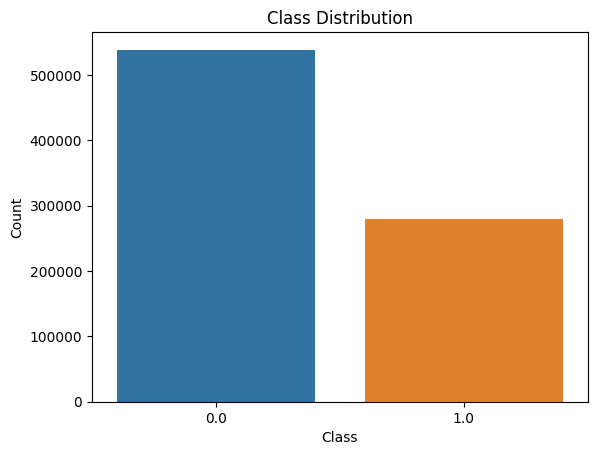

In [10]:
sns.countplot(data=data, x='Label', hue='Label', dodge=False, legend=False)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

## Dimensionality reduction

In [11]:
# pca = PCA(n_components = 0.90)

# data_reduced = pca.fit_transform(data)

# print(f"Original shape: {data.shape}")
# print(f"Reduced shape: {data_reduced.shape}")

## Data splitting

In [12]:
from sklearn.model_selection import train_test_split
import pandas as pd

data = pd.DataFrame(data, columns=columns)

X = data.drop("Label", axis=1)
y = data["Label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(572766, 30) (245472, 30) (572766,) (245472,)


In [13]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

print("Original class distribution:\n", y_train.value_counts())

smote = SMOTE(sampling_strategy=0.8, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("After SMOTE:\n", y_train_smote.value_counts())


Original class distribution:
 Label
0.0    377163
1.0    195603
Name: count, dtype: int64
After SMOTE:
 Label
0.0    377163
1.0    301730
Name: count, dtype: int64


In [14]:
undersample = RandomUnderSampler(sampling_strategy=1, random_state=42)
X_train_resampled, y_train_resampled = undersample.fit_resample(X_train_smote, y_train_smote)

# Print new class distribution after resampling
print("Resampled class distribution:\n", y_train_resampled.value_counts())

# Verify shapes
print(X_train_resampled.shape, X_test.shape, y_train_resampled.shape, y_test.shape)

Resampled class distribution:
 Label
0.0    301730
1.0    301730
Name: count, dtype: int64
(603460, 30) (245472, 30) (603460,) (245472,)


## Ensemble Learning

### Bagging: Random Forest

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

deb = time.time()
rf_model.fit(X_train_resampled, y_train_resampled)
fin = time.time()

y_pred_rf = rf_model.predict(X_test)
time_rf = fin-deb
print("Time taken:", time_rf)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print(f"Random Forest - Accuracy: {accuracy_rf}, Precision: {precision_rf}, Recall: {recall_rf}, F1-Score: {f1_rf}")

Time taken: 703.9867479801178
Random Forest - Accuracy: 0.8399043475426933, Precision: 0.7987237116712153, Recall: 0.7111140226544541, F1-Score: 0.7523770517627044


### Boosting: XGBoost

In [ ]:
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss')

deb = time.time()
xgb_model.fit(X_train_resampled, y_train_resampled)
fin = time.time()

y_pred_xgb = xgb_model.predict(X_test)
time_xgb = fin-deb
print("Time taken:", time_xgb)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print(f"XGBoost - Accuracy: {accuracy_xgb}, Precision: {precision_xgb}, Recall: {recall_xgb}, F1-Score: {f1_xgb}")

c:\Users\miche\Documents\Erasmus\DeVinci\Advanced ML II\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:33:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Time taken: 2.809583902359009
XGBoost - Accuracy: 0.8420430843436318, Precision: 0.7925791620799068, Recall: 0.7289326679133366, F1-Score: 0.7594247139701685


In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param_grid = {
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.7, 1.0],     
    'colsample_bytree': [0.7, 1.0],
    'n_estimators': [100, 200],
    'reg_alpha': [0, 0.1],     
    'reg_lambda': [1, 10],  
}

xgb_clf = xgb.XGBClassifier(eval_metric='mlogloss', device='cuda')
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='f1', cv=3, verbose=1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Best parameters
print(f"Best parameters: {grid_search.best_params_}")

# Use best model
best_xgb_model = grid_search.best_estimator_


Fitting 3 folds for each of 128 candidates, totalling 384 fits


c:\Users\miche\Documents\Erasmus\DeVinci\Advanced ML II\venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.7}


In [ ]:
xgb_model = best_xgb_model

deb = time.time()
xgb_model.fit(X_train_resampled, y_train_resampled)
fin = time.time()

y_pred_xgb = xgb_model.predict(X_test)
time_xgb = fin-deb
print("Time taken:", time_xgb)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print(f"XGBoost - Accuracy: {accuracy_xgb}, Precision: {precision_xgb}, Recall: {recall_xgb}, F1-Score: {f1_xgb}")

Time taken: 2.3314661979675293
XGBoost - Accuracy: 0.843138932342589, Precision: 0.7953192816487772, Recall: 0.7289803113498576, F1-Score: 0.7607062289091485


### 3. Evolutionary Learning Implementation with DEAP


In [15]:
X_train_numpy = X_train_resampled.to_numpy()
X_test_numpy = X_test.to_numpy()

In [ ]:
from deap import base, creator, tools, algorithms
import random
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
from tqdm import tqdm

# Create Fitness and Individual classes
creator.create("FitnessMulti", base.Fitness, weights=(1.0, 1.0, 1.0, 1.0))  # Four metrics to optimize
creator.create("Individual", list, fitness=creator.FitnessMulti)

generation_metrics = []

# Placeholder for the model (ensure this is pre-trained)
model = xgb.XGBClassifier(eval_metric='mlogloss', device='cuda')

# Evaluation function for symbolic regression
def evalSymbReg(individual):
    start_time = time.time()

    # Select features based on the binary individual representation
    selected_features = np.where(np.array(individual) == 1)[0]

    if len(selected_features) == 0:  # Avoid training on an empty feature set
        return (0, 0, 0, 0)

    X_train_sub = X_train_numpy[:, selected_features]
    X_test_sub = X_test_numpy[:, selected_features]

    # Train and predict with XGBoost
    model.fit(X_train_sub, y_train_resampled)
    y_pred = model.predict(X_test_sub)

    # Compute metrics
    accuracy_deap_xgb = accuracy_score(y_test, y_pred)
    precision_deap_xgb = precision_score(y_test, y_pred)
    recall_deap_xgb = recall_score(y_test, y_pred)
    f1_deap_xgb = f1_score(y_test, y_pred)

    # Time tracking
    time_deap_xgb = time.time() - start_time

    return (accuracy_deap_xgb, precision_deap_xgb, recall_deap_xgb, f1_deap_xgb)


# Evolutionary algorithm functions
toolbox = base.Toolbox()
toolbox.register("attr_bool", lambda: random.choice([0, 1]))  # Binary feature selection
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Operators
toolbox.register("mate", tools.cxUniform, indpb=0.5)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)  # Reduced mutation rate
toolbox.register("select", tools.selNSGA2)  # Multi-objective selection
toolbox.register("evaluate", evalSymbReg)

hof = tools.HallOfFame(1)  # Store best individual

# Train with eaSimple
def train_eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=None, verbose=True):
    start = time.time()
    for gen in tqdm(range(ngen), desc="Generations (eaSimple)", unit="gen", ncols=100, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [Elapsed: {elapsed}] [Remaining: {remaining}]"):
        # Population for eaSimple (uniform size)
        pop = toolbox.population(n=100)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", lambda pop: np.mean(pop, axis=0))
        stats.register("max", lambda pop: np.max(pop, axis=0))

        # Run the evolutionary algorithm (eaSimple)
        algorithms.eaSimple(pop, toolbox, cxpb=0.6, mutpb=0.3, ngen=20, stats=stats, halloffame=hof, verbose=True)

    print("Best Individual (Features):", hof[0])
    end = time.time()
    time_deap_simple = end-start

# Train with eaMuPlusLambda
def train_eaMuPlusLambda(population, toolbox, cxpb, mutpb, ngen, stats=None, verbose=True):
    start = time.time()
    for gen in tqdm(range(ngen), desc="Generations (eaMuPlusLambda)", unit="gen", ncols=100, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [Elapsed: {elapsed}] [Remaining: {remaining}]"):
        # Population for eaMuPlusLambda
        pop = toolbox.population(n=100)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", lambda pop: np.mean(pop, axis=0))
        stats.register("max", lambda pop: np.max(pop, axis=0))

        # Run the evolutionary algorithm (eaMuPlusLambda)
        algorithms.eaMuPlusLambda(pop, toolbox, mu=100, lambda_=200, cxpb=0.6, mutpb=0.3, ngen=20, stats=stats, halloffame=hof, verbose=True)

    print("Best Individual (Features):", hof[0])
    end = time.time()
    time_deap_plus_lambda = end-start


# Evaluate both models
def evaluate_model(model, X_test, y_test, selected_features):
    X_test_sub = X_test[:, selected_features]
    y_pred = model.predict(X_test_sub)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1

c:\Users\miche\Documents\Erasmus\DeVinci\Advanced ML II\venv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\miche\Documents\Erasmus\DeVinci\Advanced ML II\venv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [20]:
train_eaSimple(population=None, toolbox=toolbox, cxpb=0.6, mutpb=0.3, ngen=20)
best_individual_eaSimple = hof[0]

# Extract the selected features (best individual)
selected_features_simple = np.where(np.array(best_individual_eaSimple) == 1)[0]

# Evaluate the model performance using selected features from eaSimple
accuracy_deap_simple, precision_deap_simple, recall_deap_simple, f1_deap_simple = evaluate_model(best_xgb_model, X_test_numpy, y_test, selected_features_simple)
print(f"eaSimple - Accuracy: {accuracy_deap_simple}, Precision: {precision_deap_simple}, Recall: {recall_deap_simple}, F1-Score: {f1_deap_simple}")


# Evaluate `eaMuPlusLambda`
train_eaMuPlusLambda(population=None, toolbox=toolbox, cxpb=0.6, mutpb=0.3, ngen=20)
best_individual_eaMuPlusLambda = hof[0]

# Extract the selected features (best individual)
selected_features_muplambda = np.where(np.array(best_individual_eaMuPlusLambda) == 1)[0]

# Evaluate the model performance using selected features from eaMuPlusLambda
accuracy_deap_plus_lambda, precision_deap_plus_lambda, recall_deap_plus_lambda, f1_deap_plus_lambda = evaluate_model(best_xgb_model, X_test_numpy, y_test, selected_features_muplambda)
print(f"eaMuPlusLambda - Accuracy: {accuracy_deap_plus_lambda}, Precision: {precision_deap_plus_lambda}, Recall: {recall_deap_plus_lambda}, F1-Score: {f1_deap_plus_lambda}")

Generations (eaSimple):   0%|                                 | 0/20 [Elapsed: 01:40] [Remaining: ?]


KeyboardInterrupt: 

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metrics_subplots(generation_metrics):
    if not generation_metrics:  # Check if the generation_metrics list is empty
        print("No data to plot.")
        return

    # Convert generation_metrics to a numpy array with the right shape
    generation_metrics_array = np.array([
        [gen["Accuracy"], gen["Precision"], gen["Recall"], gen["F1"]] 
        for gen in generation_metrics
    ])

    # Labels for the metrics
    labels = ['Accuracy', 'Precision', 'Recall', 'F1']

    # Create subplots (4 subplots in a 2x2 grid)
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()  # Flatten the axes array for easier iteration

    # Plot each metric on a separate subplot
    for i, metric in enumerate(generation_metrics_array.T):  # iterate over each metric (column)
        axes[i].plot(range(1, len(generation_metrics_array) + 1), metric, label=labels[i])
        axes[i].set_xlabel("Generation")
        axes[i].set_ylabel("Metric Value")
        axes[i].set_title(f"{labels[i]} Over Generations")
        axes[i].legend()
    
    plt.tight_layout()  # Adjust the layout to avoid overlap
    plt.show()

# Example usage (After the evolutionary process)
plot_metrics_subplots(generation_metrics)


No data to plot.


### Performance Evaluation 

In [ ]:
# # Performance evaluation function for all models
# def evaluate_performance(model, X_train, X_test, y_train, y_test):
#     start_time = time.time()
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     end_time = time.time()
    
#     metrics = {
#         "Accuracy": accuracy_score(y_test, y_pred),
#         "Precision": precision_score(y_test, y_pred),
#         "Recall": recall_score(y_test, y_pred),
#         "F1-Score": f1_score(y_test, y_pred),
#         "Training Time": end_time - start_time
#     }
#     return metrics

# # Compare performances
# results = {
#     "Random Forest": evaluate_performance(rf_model, X_train, X_test, y_train, y_test),
#     "XGBoost": evaluate_performance(xgb_model, X_train, X_test, y_train, y_test),
#     # Add evolutionary learning model results here
# }

# # Output results
# for model_name, metrics in results.items():
#     print(f"{model_name} Performance:")
#     for metric, value in metrics.items():
#         print(f"{metric}: {value}")
#     print("\n")


### Comparative analysis

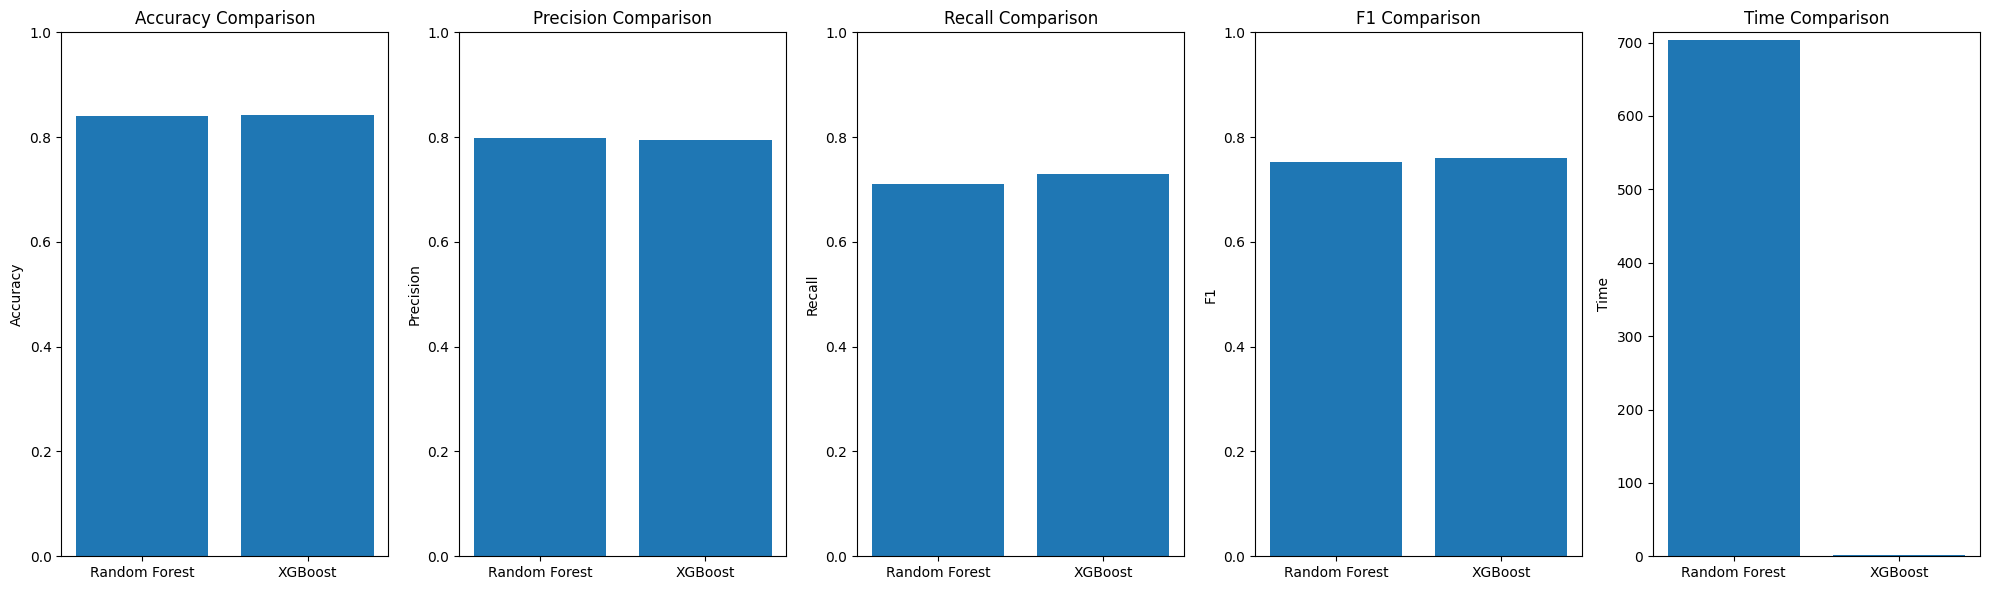

In [ ]:
results = {
    "Random Forest": {"Accuracy": accuracy_rf, "Precision": precision_rf, "Recall": recall_rf, "F1": f1_rf, "Time": time_rf},
    "XGBoost": {"Accuracy": accuracy_xgb, "Precision": precision_xgb, "Recall": recall_xgb, "F1": f1_xgb, "Time": time_xgb},
    "DEAP Simple": {"Accuracy": accuracy_deap_simple, "Precision": precision_deap_simple, "Recall": recall_deap_simple, "F1": f1_deap_simple, "Time": time_deap_simple},
    "DEAP Plus Lambda": {"Accuracy": accuracy_deap_plus_lambda, "Precision": precision_deap_plus_lambda, "Recall": recall_deap_plus_lambda, "F1": f1_deap_plus_lambda, "Time": time_deap_plus_lambda},
}

models = list(results.keys())
metrics = ["Accuracy", "Precision", "Recall", "F1"]
time_metric = ["Time"]

# Create subplots, 2 rows, 2 columns for metrics and 1 row for the time metric
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot Accuracy, Precision, Recall, and F1 in a single subplot (4 metrics together)
for i, metric in enumerate(metrics):
    axes[0, i].bar(models, [results[model][metric] for model in models])
    axes[0, i].set_title(f'{metric} Comparison')
    axes[0, i].set_ylabel(metric)
    axes[0, i].set_ylim(0, 1)  # For metrics like Accuracy, Precision, etc.

# Plot Time in a separate subplot
axes[1, 0].bar(models, [results[model]["Time"] for model in models])
axes[1, 0].set_title('Time Comparison')
axes[1, 0].set_ylabel('Time (seconds)')
axes[1, 0].set_ylim(0, max(results[model]["Time"] for model in models) + 10)

# Remove the extra subplot (1, 1) to avoid empty subplot
fig.delaxes(axes[1, 1])

# Adjust layout to prevent overlapping of labels
plt.tight_layout()
plt.show()

## Ensemble Learning

### Bagging: Random Forest

In [13]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

deb = time.time()
rf_model.fit(X_train, y_train)
fin = time.time()

y_pred_rf = rf_model.predict(X_test)
time_rf = fin-deb
print("Time taken:", time_rf)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print(f"Random Forest - Accuracy: {accuracy_rf}, Precision: {precision_rf}, Recall: {recall_rf}, F1-Score: {f1_rf}")

Time taken: 703.9867479801178
Random Forest - Accuracy: 0.8399043475426933, Precision: 0.7987237116712153, Recall: 0.7111140226544541, F1-Score: 0.7523770517627044


### Boosting: XGBoost

In [14]:
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss')

deb = time.time()
xgb_model.fit(X_train, y_train)
fin = time.time()

y_pred_xgb = xgb_model.predict(X_test)
time_xgb = fin-deb
print("Time taken:", time_xgb)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print(f"XGBoost - Accuracy: {accuracy_xgb}, Precision: {precision_xgb}, Recall: {recall_xgb}, F1-Score: {f1_xgb}")

c:\Users\miche\Documents\Erasmus\DeVinci\Advanced ML II\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:33:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Time taken: 2.809583902359009
XGBoost - Accuracy: 0.8420430843436318, Precision: 0.7925791620799068, Recall: 0.7289326679133366, F1-Score: 0.7594247139701685


In [22]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param_grid = {
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.7, 1.0],     
    'colsample_bytree': [0.7, 1.0],
    'n_estimators': [100, 200],
    'reg_alpha': [0, 0.1],     
    'reg_lambda': [1, 10],  
}

xgb_clf = xgb.XGBClassifier(eval_metric='mlogloss', device='cuda')
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='f1', cv=3, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters
print(f"Best parameters: {grid_search.best_params_}")

# Use best model
best_xgb_model = grid_search.best_estimator_


Fitting 3 folds for each of 128 candidates, totalling 384 fits


c:\Users\miche\Documents\Erasmus\DeVinci\Advanced ML II\venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.7}


In [23]:
xgb_model = best_xgb_model

deb = time.time()
xgb_model.fit(X_train, y_train)
fin = time.time()

y_pred_xgb = xgb_model.predict(X_test)
time_xgb = fin-deb
print("Time taken:", time_xgb)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print(f"XGBoost - Accuracy: {accuracy_xgb}, Precision: {precision_xgb}, Recall: {recall_xgb}, F1-Score: {f1_xgb}")

Time taken: 2.3314661979675293
XGBoost - Accuracy: 0.843138932342589, Precision: 0.7953192816487772, Recall: 0.7289803113498576, F1-Score: 0.7607062289091485


### 3. Evolutionary Learning Implementation with DEAP


In [15]:
X_train_numpy = X_train.to_numpy()
X_test_numpy = X_test.to_numpy()

In [33]:
creator.create("FitnessMulti", base.Fitness, weights=(1.0, 1.0, 1.0, 1.0))  # Four metrics to optimize
creator.create("Individual", list, fitness=creator.FitnessMulti)

generation_metrics = []

model = best_xgb_model
    
def evalSymbReg(individual):
    start_time = time.time()

    # Select features based on the binary individual representation
    selected_features = np.where(np.array(individual) == 1)[0]

    if len(selected_features) == 0:  # Avoid training on an empty feature set
        return (0, 0, 0, 0)

    X_train_sub = X_train_numpy[:, selected_features]
    X_test_sub = X_test_numpy[:, selected_features]

    # Train and predict with XGBoost
    model = best_xgb_model
    model.fit(X_train_sub, y_train)
    y_pred = model.predict(X_test_sub)

    # Compute metrics
    accuracy_deap_xgb = accuracy_score(y_test, y_pred)
    precision_deap_xgb = precision_score(y_test, y_pred)
    recall_deap_xgb = recall_score(y_test, y_pred)
    f1_deap_xgb = f1_score(y_test, y_pred)

    # Time tracking
    time_deap_xgb = time.time() - start_time

    return (accuracy_deap_xgb, precision_deap_xgb, recall_deap_xgb, f1_deap_xgb)


# Evolutionary algorithm functions
toolbox = base.Toolbox()
toolbox.register("attr_bool", lambda: random.choice([0, 1]))  # Binary feature selection
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Operators
toolbox.register("mate", tools.cxUniform, indpb=0.5)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)  # Reduced mutation rate
toolbox.register("select", tools.selNSGA2)  # Multi-objective selection
toolbox.register("evaluate", evalSymbReg)

hof = tools.HallOfFame(1)  # Store best individual


def eaSimple_with_progress_bar(population, toolbox, cxpb, mutpb, ngen, stats=None, verbose=True):
    for gen in tqdm(range(ngen), desc="Generations", unit="gen", ncols=100, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [Elapsed: {elapsed}] [Remaining: {remaining}]"):
        pop = toolbox.population(n=100)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", lambda pop: np.mean(pop, axis=0))
        stats.register("max", lambda pop: np.max(pop, axis=0))
        
        # Use a Pareto-based multi-objective algorithm
        algorithms.eaMuPlusLambda(pop, toolbox, mu=100, lambda_=200, cxpb=0.6, mutpb=0.3,
                                ngen=20, stats=stats, halloffame=hof, verbose=True)
        
        print("Best Individual (Features):", hof[0])

c:\Users\miche\Documents\Erasmus\DeVinci\Advanced ML II\venv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\miche\Documents\Erasmus\DeVinci\Advanced ML II\venv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [34]:
eaSimple_with_progress_bar(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=5, verbose=True)

Generations:   0%|                                             | 0/5 [Elapsed: 00:00] [Remaining: ?]


GENERATION 0


Generations:  20%|████████▏                                | 1/5 [Elapsed: 01:39] [Remaining: 06:39]

Best Individual: [11, 10, 17, 10, 1, 4, 24, 2, 0, 9]

GENERATION 1


Generations:  40%|████████████████▍                        | 2/5 [Elapsed: 03:46] [Remaining: 05:47]

Best Individual: [11, 10, 17, 10, 0, 4, 24, 2, 1, 9]

GENERATION 2


Generations:  60%|████████████████████████▌                | 3/5 [Elapsed: 05:16] [Remaining: 03:28]

Best Individual: [11, 10, 17, 10, 0, 4, 24, 2, 1, 9]

GENERATION 3


Generations:  80%|████████████████████████████████▊        | 4/5 [Elapsed: 06:05] [Remaining: 01:22]

Best Individual: [11, 10, 17, 10, 0, 4, 24, 2, 1, 9]

GENERATION 4


Generations: 100%|█████████████████████████████████████████| 5/5 [Elapsed: 06:42] [Remaining: 00:00]

Best Individual: [11, 10, 17, 10, 0, 4, 24, 2, 1, 9]


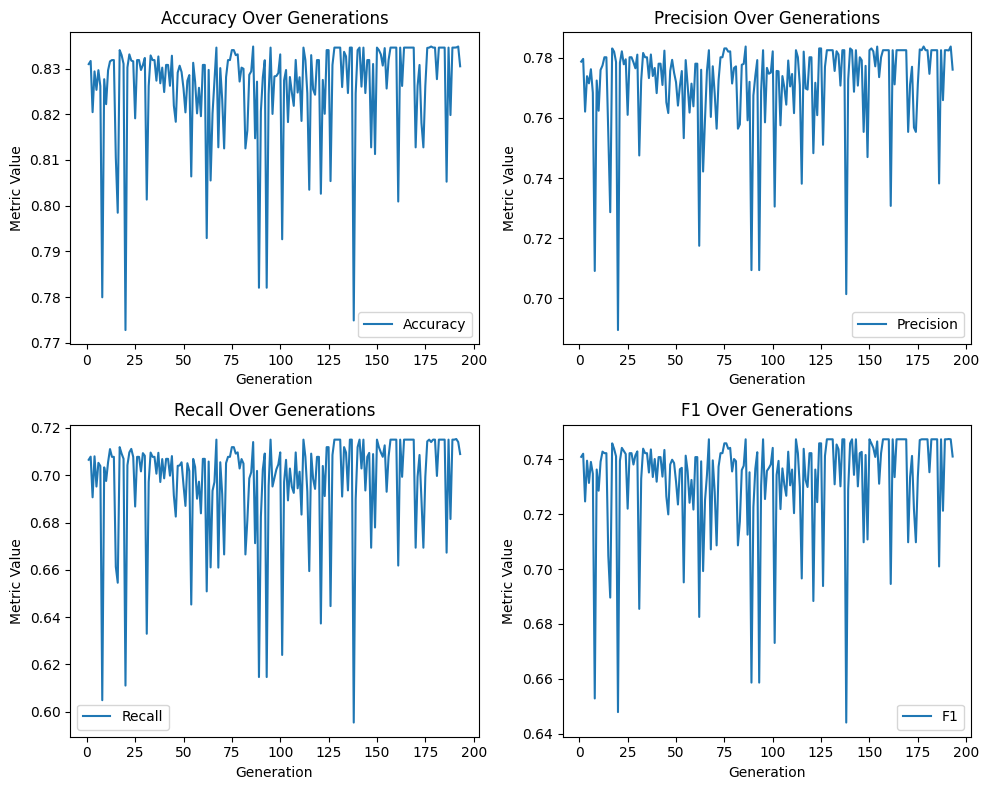

In [35]:
generation_metrics_array = np.array([
    [gen["Accuracy"], gen["Precision"], gen["Recall"], gen["F1"]] 
    for gen in generation_metrics
])
def plot_metrics_subplots(metrics):
    labels = ['Accuracy', 'Precision', 'Recall', 'F1']
    
    # Create subplots (4 subplots in a 2x2 grid)
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()  # Flatten the axes array for easier iteration
    
    for i, metric in enumerate(metrics.T):  # iterate over each metric (column)
        axes[i].plot(range(1, len(metrics) + 1), metric, label=labels[i])
        axes[i].set_xlabel("Generation")
        axes[i].set_ylabel("Metric Value")
        axes[i].set_title(f"{labels[i]} Over Generations")
        axes[i].legend()
    
    plt.tight_layout()  # Adjust the layout to avoid overlap
    plt.show()

# After the evolutionary process, plot the metrics
plot_metrics_subplots(generation_metrics_array)

### Performance Evaluation 

In [36]:
# # Performance evaluation function for all models
# def evaluate_performance(model, X_train, X_test, y_train, y_test):
#     start_time = time.time()
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     end_time = time.time()
    
#     metrics = {
#         "Accuracy": accuracy_score(y_test, y_pred),
#         "Precision": precision_score(y_test, y_pred),
#         "Recall": recall_score(y_test, y_pred),
#         "F1-Score": f1_score(y_test, y_pred),
#         "Training Time": end_time - start_time
#     }
#     return metrics

# # Compare performances
# results = {
#     "Random Forest": evaluate_performance(rf_model, X_train, X_test, y_train, y_test),
#     "XGBoost": evaluate_performance(xgb_model, X_train, X_test, y_train, y_test),
#     # Add evolutionary learning model results here
# }

# # Output results
# for model_name, metrics in results.items():
#     print(f"{model_name} Performance:")
#     for metric, value in metrics.items():
#         print(f"{metric}: {value}")
#     print("\n")


### Comparative analysis

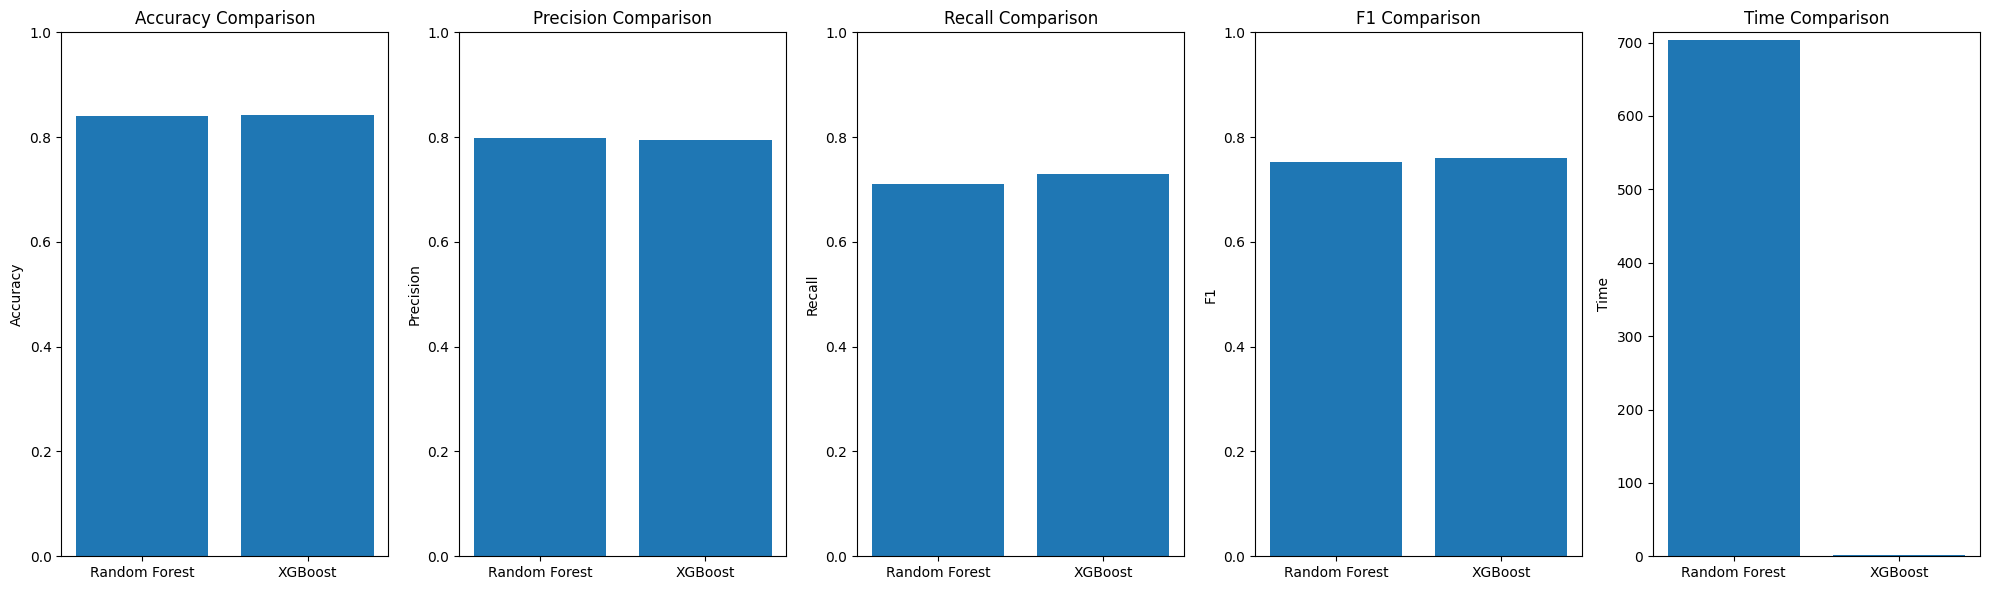

In [37]:
results = {
    "Random Forest": {"Accuracy": accuracy_rf, "Precision": precision_rf, "Recall": recall_rf, "F1": f1_rf, "Time": time_rf},
    "XGBoost": {"Accuracy": accuracy_xgb, "Precision": precision_xgb, "Recall": recall_xgb, "F1": f1_xgb, "Time": time_xgb},
    # Add evolutionary learning model results here
}

models = list(results.keys())
metrics = ["Accuracy", "Precision", "Recall", "F1", "Time"]

# Prepare the figure and axes
fig, axes = plt.subplots(1, len(metrics), figsize=(20, 6))

# For each metric, plot the values across models
for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.bar(models, [results[model][metric] for model in models])
    ax.set_title(f'{metric} Comparison')
    ax.set_ylabel(metric)
    ax.set_ylim(0, 1) if metric != 'Time' else ax.set_ylim(0, max(results[model]["Time"] for model in models) + 10)

# Adjust layout to prevent overlapping of labels
plt.tight_layout()
plt.show()